# Denoise Image with AutoEncoder

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from PIL import Image

In [18]:
# set up the path for both training and testing data
data_address = os.path.join(os.getcwd(),'..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


### Load and Preprocess Images

In [19]:
number_of_figures = 100
output_folder = "../Data/autoencoder_denoised_training_images_sample"
os.makedirs(output_folder, exist_ok=True)

In [20]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image to grayscale
    img = img.convert('L')
    # Resize the image
    img = img.resize(target_size)
    # Convert the image data to a numpy array and normalize
    img_array = np.array(img) / 255.
    return img_array


In [21]:
# Load and preprocess the images
x_train_normal = np.array([load_and_preprocess_image(path) for path in train_images_normal[:number_of_figures]])
x_train_sick = np.array([load_and_preprocess_image(path) for path in train_images_sick[:number_of_figures]])
x_test_normal = np.array([load_and_preprocess_image(path) for path in test_images_normal[:number_of_figures]])
x_test_sick = np.array([load_and_preprocess_image(path) for path in test_images_sick[:number_of_figures]])

# Concatenate normal and sick images to create full train and test sets
x_train = np.concatenate((x_train_normal, x_train_sick))
x_test = np.concatenate((x_test_normal, x_test_sick))


In [ ]:
# Reshape to include channel dimension (1 channel for grayscale images)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

### Train the Autoencoder without artificial noise

In [37]:
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [40]:
# Train the autoencoder
autoencoder.fit(x_train, x_train,  # Use the original images as both input and target
                epochs=20,
                batch_size=128,
                shuffle=True)

# Denoise the test images
denoised_images = autoencoder.predict(x_test)


Epoch 1/20
2/2 [==============================] - 4s 1s/step - loss: 0.6923
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.6923
Epoch 3/20
2/2 [==============================] - 3s 873ms/step - loss: 0.6923
Epoch 4/20
2/2 [==============================] - 3s 872ms/step - loss: 0.6923
Epoch 5/20
2/2 [==============================] - 3s 863ms/step - loss: 0.6923
Epoch 6/20
2/2 [==============================] - 3s 1s/step - loss: 0.6923
Epoch 7/20
2/2 [==============================] - 3s 877ms/step - loss: 0.6923
Epoch 8/20
2/2 [==============================] - 3s 848ms/step - loss: 0.6922
Epoch 9/20
2/2 [==============================] - 3s 912ms/step - loss: 0.6922
Epoch 10/20
2/2 [==============================] - 3s 887ms/step - loss: 0.6922
Epoch 11/20
2/2 [==============================] - 3s 987ms/step - loss: 0.6922
Epoch 12/20
2/2 [==============================] - 3s 982ms/step - loss: 0.6922
Epoch 13/20
2/2 [==============================] - 3s 935m

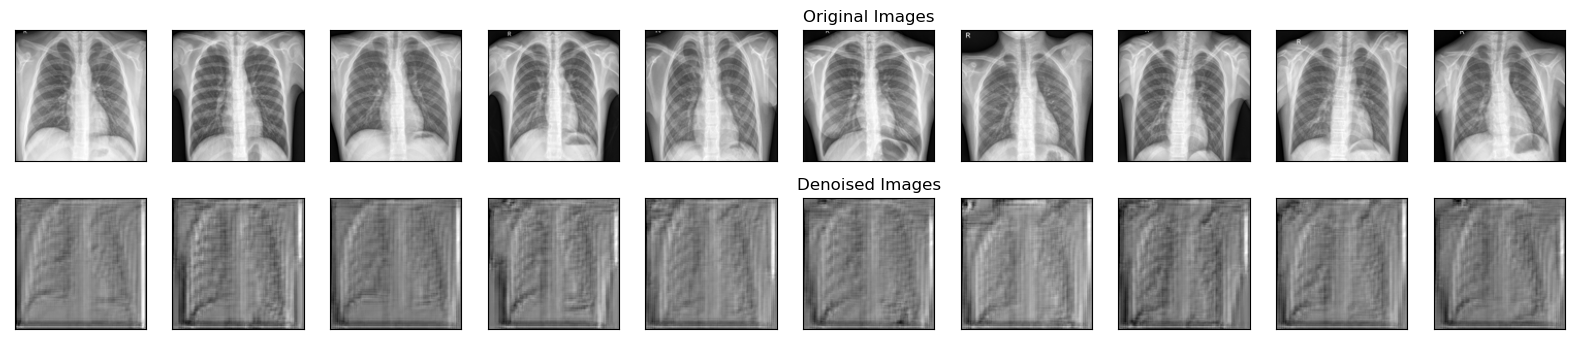

In [42]:
n = 10  # number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original Images')

    # Denoised Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Denoised Images')
        
plt.show()

In [44]:
for i in range(len(denoised_images)):
    img = denoised_images[i].squeeze()  # Remove the channel dimension
    img = img * 255.0  # Convert the images from float to uint8
    img = Image.fromarray(img.astype('uint8'), 'L')  # Convert array to grayscale image
    img.save(os.path.join(output_folder, f'denoised_image_{i+1}.png'))

Show average results

In [46]:
# making n X m matrix
def img2np(list_of_filename, size = (500, 500)):
    # iterating through each file
    for i,fn in enumerate(list_of_filename):
        current_image = image.load_img(fn, target_size = size, color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

## Image comparison
def find_mean_img(full_mat, title, size = (500, 500)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

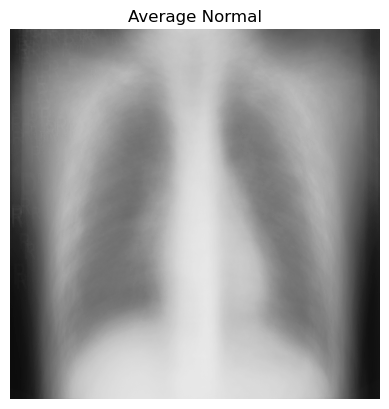

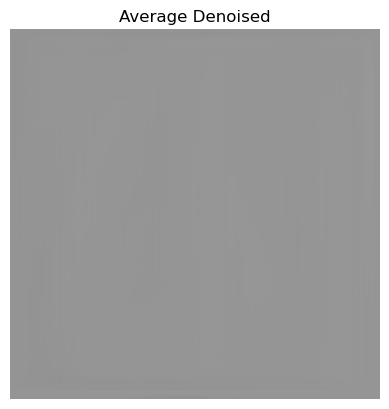

In [50]:
path_draw = test_images_normal[:number_of_figures]
original = img2np(path_draw)
norm_mean = find_mean_img(original, 'Normal')

denoised = img2np([os.path.join(output_folder, f"denoised_image_{i+1}.png") for i in range(number_of_figures)])
denoised_mean = find_mean_img(denoised, 'Denoised')

### Train the Autoencoder with artificial noise

In [23]:
# Add random noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [33]:
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_noisy = Model(input_img, decoded)
autoencoder_noisy.compile(optimizer='adadelta', loss='binary_crossentropy')

In [34]:
# train the autoencoder
autoencoder_noisy.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True)


Epoch 1/20
2/2 [==============================] - 4s 968ms/step - loss: 0.6938
Epoch 2/20
2/2 [==============================] - 3s 1s/step - loss: 0.6937
Epoch 3/20
2/2 [==============================] - 4s 1s/step - loss: 0.6937
Epoch 4/20
2/2 [==============================] - 4s 1s/step - loss: 0.6937
Epoch 5/20
2/2 [==============================] - 3s 1s/step - loss: 0.6937
Epoch 6/20
2/2 [==============================] - 4s 1s/step - loss: 0.6937
Epoch 7/20
2/2 [==============================] - 3s 1s/step - loss: 0.6937
Epoch 8/20
2/2 [==============================] - 4s 1s/step - loss: 0.6937
Epoch 9/20
2/2 [==============================] - 4s 1s/step - loss: 0.6937
Epoch 10/20
2/2 [==============================] - 4s 1s/step - loss: 0.6936
Epoch 11/20
2/2 [==============================] - 4s 1s/step - loss: 0.6936
Epoch 12/20
2/2 [==============================] - 4s 1s/step - loss: 0.6936
Epoch 13/20
2/2 [==============================] - 3s 924ms/step - loss: 0.6936
Ep

### Evaluate the denoised images

In [35]:
# Denoise the test images
denoised_images = autoencoder.predict(x_test_noisy)

7/7 [==============================] - 0s 67ms/step


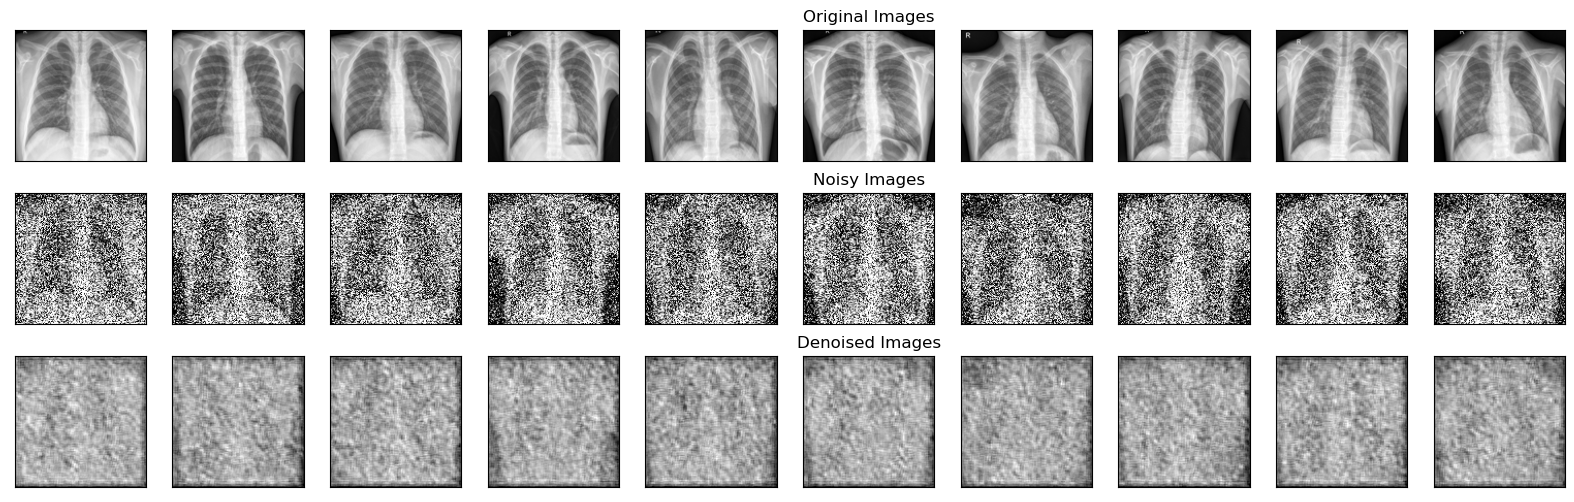

In [36]:
n = 10  # number of images to display

plt.figure(figsize=(20, 6))

for i in range(n):
    # Original Images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original Images')

    # Noisy Images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Noisy Images')

    # Denoised Images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Denoised Images')
        
plt.show()
